# Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Import Libraries

In [44]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from datetime import datetime
from pathlib import Path
import pandas as pd
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
import torch.nn.functional as F

# Import Dataset

In [45]:
 data = pd.read_csv('/content/gdrive/My Drive/NLP/Lecture_5/airline.csv', encoding = "ISO-8859-1")

In [46]:
data.head()

,Id,text,Target
0,1,@USAirways ! THE WORST in customer service. @...,-1
1,2,@united call wait times are over 20 minutes an...,-1
2,3,@JetBlue what's up with the random delay on fl...,-1
3,4,@AmericanAir Good morning! Wondering why my p...,0
4,5,@united UA 746. Pacific Rim and Date Night cut...,-1


In [47]:
data.shape

(7320, 3)

# Make Target Range between - 0 & 1

In [48]:
data['Target']= data['Target'] +1

In [49]:
data.head()

,Id,text,Target
0,1,@USAirways ! THE WORST in customer service. @...,0
1,2,@united call wait times are over 20 minutes an...,0
2,3,@JetBlue what's up with the random delay on fl...,0
3,4,@AmericanAir Good morning! Wondering why my p...,1
4,5,@united UA 746. Pacific Rim and Date Night cut...,0


In [50]:
data['Target'].value_counts()

0    4566
1    1536
2    1218
Name: Target, dtype: int64

# Pre-Processing 

In [51]:
def nltk_treebank_stemmer_tokenizer(data):
  tokenizer= TreebankWordTokenizer()
  stemmer = PorterStemmer()
  tokens= tokenizer.tokenize(data)
  return [stemmer.stem(token) for token in tokens]

In [52]:
	def read_data(filename, tokenizer):
		corpus=[]
		Y=[]
		for i in range(len(data)):
		#id=dat['Id']
			text=data['text'][i]
		#print(cols)
			label= data['Target'][i]
			tokens=' '.join(tokenizer(text))
			corpus.append(tokens)
			Y.append(label)
		
		
		return corpus, Y

In [53]:
corpus, labels=read_data(data, nltk_treebank_stemmer_tokenizer)

In [54]:
vectorizer = CountVectorizer(max_features=1000, analyzer=str.split, lowercase=False, strip_accents=None, binary=True, ngram_range=(1,3))

In [55]:
y = np.array(labels)

In [56]:
# separate into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    corpus,  # predictors
    labels,  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

In [57]:
X_train = vectorizer.fit_transform(X_train).todense()
X_test = vectorizer.transform(X_test).todense()

In [58]:
X_train = torch.tensor(X_train).float()
y_train=torch.tensor(y_train)

In [59]:
X_test = torch.tensor(X_test).float()
y_test=torch.tensor(y_test)

In [60]:
from torch.utils import data
train_dataset = data.TensorDataset(X_train,y_train)

In [61]:
test_dataset = data.TensorDataset(X_test,y_test)

In [62]:
batch_size=100
train_loader= torch.utils.data.DataLoader(dataset=train_dataset,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        num_workers=4)

In [63]:
test_loader= torch.utils.data.DataLoader(dataset=test_dataset,
                                        batch_size=batch_size,
                                        shuffle=False,
                                        num_workers=4)

# Q1 

- Build a DNN with 20 hidden layers of 100 neurons each (that’s too many, but it’s the point of this exercise). Use He initialization and the ELU activation function.

In [64]:
class He_Relu(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, output_dim):
        super(He_Relu, self).__init__()
        
        # Linear function - hidden 1
        self.fc1 = nn.Linear(input_dim, hidden_dim_1) 
        # Weight initialization
        nn.init.kaiming_normal_(self.fc1.weight)

        
        # Linear function - hidden 2
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2) 
        # Weight initialization
        nn.init.kaiming_normal_(self.fc2.weight)
 
       
        # Linear function - output
        self.fc3 = nn.Linear(hidden_dim_2, output_dim) 
        # Weight initialization 
        nn.init.kaiming_normal_(self.fc3.weight)

        # Non-linearity
        self.relu = nn.ReLU()
    
    def forward(self, x):
                
        # Hidden-1-- Linear function
        out = self.fc1(x)
        # Non-linearity
        out = self.relu(out)

        # Hidden 2-- Linear function
        out = self.fc2(out)
        # Non-linearity
        out = self.relu(out)

        # Output-- Linear function
        out = self.fc3(out)
        return out

# STEP 4: INSTANTIATE MODEL
input_dim = 1000
hidden_dim_1 = 300
hidden_dim_2 = 100
output_dim = 3
#batch_size =256

model = He_Relu(input_dim, hidden_dim_1,hidden_dim_2,output_dim)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)



cuda:0


He_Relu(
  (fc1): Linear(in_features=1000, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=3, bias=True)
  (relu): ReLU()
)

# Q2

- Using Adam optimization and early stopping, train the network. Remember to search for the right learning rate each time you change the model’s architecture or hyper-parameters.

In [65]:
# STEP 5: INSTANTIATE LOSS CLASS
criterion = nn.CrossEntropyLoss()

# STEP 6: INSTANTIATE OPTIMIZER CLASS
learning_rate = 0.05
wd=0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=wd)

In [66]:
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=2, gamma=0.95)

In [67]:

# STEP 7: TRAIN THE MODEL
epochs=20
train_losses= np.zeros(epochs)
test_losses= np.zeros(epochs)
learning_rates=[]

for epoch in range(epochs):
  
  t0= datetime.now()
  train_loss=[]
  
  model.train()
  for input,targets in train_loader:
    # load input and output to GPU
    input = input.to(device)
    targets= targets.to(device)
    
    # forward pass
    output= model(input)
    loss=criterion(output,targets)

    # set gradients to zero 
    optimizer.zero_grad()

    # backward pass
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
  
  train_loss=np.mean(train_loss)
      
  test_loss=[]
  model.eval()
  with torch.no_grad():
    for input,targets in test_loader:
      # load input and output to GPU
      input = input.to(device)
      targets= targets.to(device)
      
      # forward pass
      output= model(input)
      loss=criterion(output,targets)
      test_loss.append(loss.item())

    test_loss=np.mean(test_loss)
  
  # save Losses
  train_losses[epoch]= train_loss
  test_losses[epoch]= test_loss
  dt= datetime.now()-t0

  learning_rates.append(scheduler.get_last_lr())
  
  print(f'Epoch {epoch+1}/{epochs}, Learning Rate : {scheduler.get_last_lr()}')
  print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}    Test Loss: {test_loss:.4f}, Duration: {dt}')
  scheduler.step() 

Epoch 1/20, Learning Rate : [0.05]
Epoch 1/20, Train Loss: 0.9502    Test Loss: 0.6770, Duration: 0:00:00.699870
Epoch 2/20, Learning Rate : [0.05]
Epoch 2/20, Train Loss: 0.6432    Test Loss: 0.6052, Duration: 0:00:00.706438
Epoch 3/20, Learning Rate : [0.0475]
Epoch 3/20, Train Loss: 0.6062    Test Loss: 0.6252, Duration: 0:00:00.719838
Epoch 4/20, Learning Rate : [0.0475]
Epoch 4/20, Train Loss: 0.6014    Test Loss: 0.6013, Duration: 0:00:00.670896
Epoch 5/20, Learning Rate : [0.045125]
Epoch 5/20, Train Loss: 0.5960    Test Loss: 0.5583, Duration: 0:00:00.711276
Epoch 6/20, Learning Rate : [0.045125]
Epoch 6/20, Train Loss: 0.5879    Test Loss: 0.5800, Duration: 0:00:00.692927
Epoch 7/20, Learning Rate : [0.04286875]
Epoch 7/20, Train Loss: 0.5909    Test Loss: 0.5442, Duration: 0:00:00.670189
Epoch 8/20, Learning Rate : [0.04286875]
Epoch 8/20, Train Loss: 0.5819    Test Loss: 0.5675, Duration: 0:00:00.695883
Epoch 9/20, Learning Rate : [0.04072531249999999]
Epoch 9/20, Train Loss

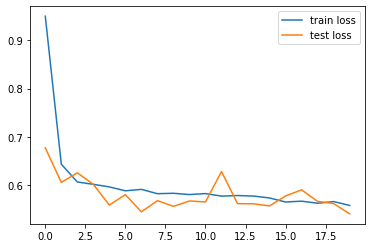

In [68]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses,label='train loss')
plt.plot(test_losses,label='test loss')
plt.legend()

In [69]:
# Accuracy- write a function to get accuracy
# use this function to get train/test accuracy and print accuracy
def get_accuracy(train_loader, test_loader, model):
  model.eval()
  with torch.no_grad():
    correct_train=correct_test=0
    total_train=total_test=0
    
    for input, targets in train_loader:
      input= input.to(device)
      targets= targets.to(device)
      #input = input.view(-1, 784)
      output=model(input)
      _,indices = torch.max(output,dim=1)
      correct_train+= (targets==indices).sum().item()
      total_train += targets.shape[0]
    
    train_acc= correct_train/total_train

    for input, targets in test_loader:
      input= input.to(device)
      targets= targets.to(device)
      #input = input.view(-1, 784)
      output=model(input)
      _,indices = torch.max(output,dim=1)
      correct_test+= (targets==indices).sum().item()
      total_test += targets.shape[0]
    
    test_acc= correct_test/total_test
    return train_acc, test_acc

In [70]:
train_acc, test_acc = get_accuracy(train_loader, test_loader, model)
print(f'Train acc: {train_acc:.4f},\t Test acc: {test_acc:.4f}')

Train acc: 0.8046,	 Test acc: 0.7951


# Q3

- Now try adding Batch Normalization and compare the learning curves: Is it converging faster than before? Does it produce a better model? How does it affect training speed?

<b>Answer</b>: Poorer Performance with poorer test results

In [71]:
# STEP 3: CREATE MODEL CLASS

class He_Relu(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, output_dim):
        super(He_Relu, self).__init__()
        
        # Linear function - hidden 1
        self.fc1 = nn.Linear(input_dim, hidden_dim_1) 
        # Weight initialization 
        nn.init.kaiming_normal_(self.fc1.weight)
        # Batch Normalization
        self.batch1= nn.BatchNorm1d(hidden_dim_1,momentum=0.9)        
       
        # Linear function - hidden 2
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2) 
        # Weight initialization 
        nn.init.kaiming_normal_(self.fc2.weight)
        # Batch Normalization
        self.batch2= nn.BatchNorm1d(hidden_dim_2,momentum=0.9)       
        
        
        # Linear function - output
        self.fc3 = nn.Linear(hidden_dim_2, output_dim) 
        # Weight initialization 
        nn.init.kaiming_normal_(self.fc3.weight)

        # Non-linearity
        self.relu = nn.ReLU()


    
    def forward(self, x):

        # Hidden-1-- Linear function
        out = self.fc1(x)
        # Non-linearity
        out = self.relu(out)
        #Batch Normalization
        #out=self.batch1(out)

        # Hidden 2-- Linear function
        out = self.fc2(out)
        # Non-linearity
        out = self.relu(out)
        #Batch Normalization
        #out=self.batch2(out)

        # Output-- Linear function
        out = self.fc3(out)
        return out

# STEP 4: INSTANTIATE MODEL
input_dim = 1000
hidden_dim_1 = 300
hidden_dim_2 = 100
output_dim = 3

model = He_Relu(input_dim, hidden_dim_1,hidden_dim_2,output_dim)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

learning_rate = 0.01
epochs=70

cuda:0


In [72]:
print(model)

He_Relu(
  (fc1): Linear(in_features=1000, out_features=300, bias=True)
  (batch1): BatchNorm1d(300, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (batch2): BatchNorm1d(100, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=100, out_features=3, bias=True)
  (relu): ReLU()
)


In [73]:
for name, param in model.named_parameters():
  print(name, param.shape)

fc1.weight torch.Size([300, 1000])
fc1.bias torch.Size([300])
batch1.weight torch.Size([300])
batch1.bias torch.Size([300])
fc2.weight torch.Size([100, 300])
fc2.bias torch.Size([100])
batch2.weight torch.Size([100])
batch2.bias torch.Size([100])
fc3.weight torch.Size([3, 100])
fc3.bias torch.Size([3])


In [74]:

# STEP 7: TRAIN THE MODEL

train_losses= np.zeros(epochs)
test_losses= np.zeros(epochs)
learning_rates=[]

for epoch in range(epochs):
  
  t0= datetime.now()
  train_loss=[]
  
  model.train()
  for input,targets in train_loader:
    # load input and output to GPU
    input = input.to(device)
    targets= targets.to(device)
    
    # forward pass
    output= model(input)
    loss=criterion(output,targets)

    # set gradients to zero 
    optimizer.zero_grad()

    # backward pass
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
  
  train_loss=np.mean(train_loss)
      
  test_loss=[]
  model.eval()
  with torch.no_grad():
    for input,targets in test_loader:
      # load input and output to GPU
      input = input.to(device)
      targets= targets.to(device)
      
      # forward pass
      output= model(input)
      loss=criterion(output,targets)
      test_loss.append(loss.item())

    test_loss=np.mean(test_loss)
  
  # save Losses
  train_losses[epoch]= train_loss
  test_losses[epoch]= test_loss
  dt= datetime.now()-t0

  learning_rates.append(scheduler.get_last_lr())
  
  print(f'Epoch {epoch+1}/{epochs}, Learning Rate : {scheduler.get_last_lr()}')
  print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}    Test Loss: {test_loss:.4f}, Duration: {dt}')
  scheduler.step() 

Epoch 1/70, Learning Rate : [0.02993684696191893]
Epoch 1/70, Train Loss: 1.0383    Test Loss: 1.0354, Duration: 0:00:00.722527
Epoch 2/70, Learning Rate : [0.02993684696191893]
Epoch 2/70, Train Loss: 1.0381    Test Loss: 1.0354, Duration: 0:00:00.707821
Epoch 3/70, Learning Rate : [0.028440004613822983]
Epoch 3/70, Train Loss: 1.0383    Test Loss: 1.0354, Duration: 0:00:00.694666
Epoch 4/70, Learning Rate : [0.028440004613822983]
Epoch 4/70, Train Loss: 1.0380    Test Loss: 1.0354, Duration: 0:00:00.717525
Epoch 5/70, Learning Rate : [0.027018004383131834]
Epoch 5/70, Train Loss: 1.0383    Test Loss: 1.0354, Duration: 0:00:00.736624
Epoch 6/70, Learning Rate : [0.027018004383131834]
Epoch 6/70, Train Loss: 1.0380    Test Loss: 1.0354, Duration: 0:00:00.711168
Epoch 7/70, Learning Rate : [0.02566710416397524]
Epoch 7/70, Train Loss: 1.0382    Test Loss: 1.0354, Duration: 0:00:00.678820
Epoch 8/70, Learning Rate : [0.02566710416397524]
Epoch 8/70, Train Loss: 1.0385    Test Loss: 1.035

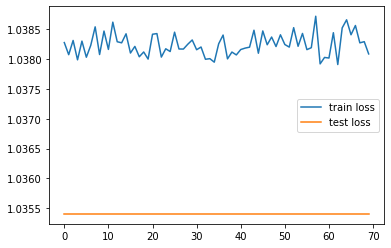

In [75]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses,label='train loss')
plt.plot(test_losses,label='test loss')
plt.legend()

In [76]:
# Accuracy- write a function to get accuracy
# use this function to get train/test accuracy and print accuracy
def get_accuracy(train_loader, test_loader, model):
  model.eval()
  with torch.no_grad():
    correct_train=correct_test=0
    total_train=total_test=0
    
    for input, targets in train_loader:
      input= input.to(device)
      targets= targets.to(device)
      #input = input.view(-1, 784)
      output=model(input)
      _,indices = torch.max(output,dim=1)
      correct_train+= (targets==indices).sum().item()
      total_train += targets.shape[0]
    
    train_acc= correct_train/total_train

    for input, targets in test_loader:
      input= input.to(device)
      targets= targets.to(device)
      #input = input.view(-1, 784)
      output=model(input)
      _,indices = torch.max(output,dim=1)
      correct_test+= (targets==indices).sum().item()
      total_test += targets.shape[0]
    
    test_acc= correct_test/total_test
    return train_acc, test_acc

In [77]:
train_acc, test_acc = get_accuracy(train_loader, test_loader, model)
print(f'Train acc: {train_acc:.4f},\t Test acc: {test_acc:.4f}')

Train acc: 0.4621,	 Test acc: 0.4679


# Q4

- Try replacing Batch Normalization with SELU, and make the necessary adjustments to ensure the network self-normalizes (i.e., standardize the input features, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers, etc.).

In [78]:
# STEP 3: CREATE MODEL CLASS

class LeSELU(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, output_dim):
        super(LeSELU, self).__init__()
        
        # Linear function - hidden 1
        self.fc1 = nn.Linear(input_dim, hidden_dim_1) 
        # Weight initialization
        # Lecun is default

        
        # Linear function - hidden 2
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2) 
        # Weight initialization
        # Lecun is default
 
       
        # Linear function - output
        self.fc3 = nn.Linear(hidden_dim_2, output_dim) 
        # Weight initialization 
        nn.init.normal_(self.fc3.weight, mean=0, std=0.01)

        # Non-linearity
        self.SELU = nn.SELU()
    
    def forward(self, x):
                
        # Hidden-1-- Linear function
        out = self.fc1(x)
        # Non-linearity
        out = self.SELU(out)

        # Hidden 2-- Linear function
        out = self.fc2(out)
        # Non-linearity
        out = self.SELU(out)

        # Output-- Linear function
        out = self.fc3(out)
        return out

# STEP 4: INSTANTIATE MODEL
input_dim = 1000
hidden_dim_1 = 300
hidden_dim_2 = 100
output_dim = 10


model = LeSELU(input_dim, hidden_dim_1,hidden_dim_2,output_dim)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)
learning_rate = 0.1
epochs=20

cuda:0


In [79]:
print(model)

LeSELU(
  (fc1): Linear(in_features=1000, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
  (SELU): SELU()
)


In [80]:
for name, param in model.named_parameters():
  print(name, param.shape)


fc1.weight torch.Size([300, 1000])
fc1.bias torch.Size([300])
fc2.weight torch.Size([100, 300])
fc2.bias torch.Size([100])
fc3.weight torch.Size([10, 100])
fc3.bias torch.Size([10])


In [81]:
# STEP 7: TRAIN THE MODEL
train_losses= np.zeros(epochs)
test_losses= np.zeros(epochs)
learning_rates=[]

for epoch in range(epochs):
  
  t0= datetime.now()
  train_loss=[]
  
  model.train()
  for input,targets in train_loader:
    # load input and output to GPU
    input = input.to(device)
    targets= targets.to(device)
    
    # forward pass
    output= model(input)
    loss=criterion(output,targets)

    # set gradients to zero 
    optimizer.zero_grad()

    # backward pass
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
  
  train_loss=np.mean(train_loss)
      
  test_loss=[]
  model.eval()
  with torch.no_grad():
    for input,targets in test_loader:
      # load input and output to GPU
      input = input.to(device)
      targets= targets.to(device)
      
      # forward pass
      output= model(input)
      loss=criterion(output,targets)
      test_loss.append(loss.item())

    test_loss=np.mean(test_loss)
  
  # save Losses
  train_losses[epoch]= train_loss
  test_losses[epoch]= test_loss
  dt= datetime.now()-t0

  learning_rates.append(scheduler.get_last_lr())
  
  print(f'Epoch {epoch+1}/{epochs}, Learning Rate : {scheduler.get_last_lr()}')
  print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}    Test Loss: {test_loss:.4f}, Duration: {dt}')
  scheduler.step() 


Epoch 1/20, Learning Rate : [0.0049720128493546106]
Epoch 1/20, Train Loss: 2.2693    Test Loss: 2.2674, Duration: 0:00:00.702789
Epoch 2/20, Learning Rate : [0.0049720128493546106]
Epoch 2/20, Train Loss: 2.2691    Test Loss: 2.2674, Duration: 0:00:00.702326
Epoch 3/20, Learning Rate : [0.00472341220688688]
Epoch 3/20, Train Loss: 2.2691    Test Loss: 2.2674, Duration: 0:00:00.710300
Epoch 4/20, Learning Rate : [0.00472341220688688]
Epoch 4/20, Train Loss: 2.2692    Test Loss: 2.2674, Duration: 0:00:00.702776
Epoch 5/20, Learning Rate : [0.004487241596542535]
Epoch 5/20, Train Loss: 2.2692    Test Loss: 2.2674, Duration: 0:00:00.705164
Epoch 6/20, Learning Rate : [0.004487241596542535]
Epoch 6/20, Train Loss: 2.2692    Test Loss: 2.2674, Duration: 0:00:00.719506
Epoch 7/20, Learning Rate : [0.004262879516715408]
Epoch 7/20, Train Loss: 2.2691    Test Loss: 2.2674, Duration: 0:00:00.698747
Epoch 8/20, Learning Rate : [0.004262879516715408]
Epoch 8/20, Train Loss: 2.2692    Test Loss: 2

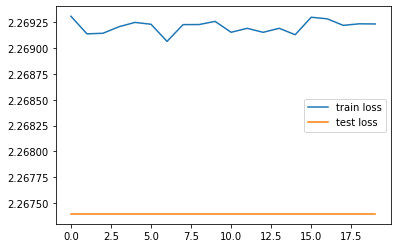

In [82]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses,label='train loss')
plt.plot(test_losses,label='test loss')
plt.legend()

In [83]:

# Accuracy- write a function to get accuracy
# use this function to get train/test accuracy and print accuracy
def get_accuracy(train_loader, test_loader, model):
  model.eval()
  with torch.no_grad():
    correct_train=correct_test=0
    total_train=total_test=0
    
    for input, targets in train_loader:
      input= input.to(device)
      targets= targets.to(device)
      #input = input.view(-1, 784)
      output=model(input)
      _,indices = torch.max(output,dim=1)
      correct_train+= (targets==indices).sum().item()
      total_train += targets.shape[0]
    
    train_acc= correct_train/total_train

    for input, targets in test_loader:
      input= input.to(device)
      targets= targets.to(device)
      #input = input.view(-1, 784)
      output=model(input)
      _,indices = torch.max(output,dim=1)
      correct_test+= (targets==indices).sum().item()
      total_test += targets.shape[0]
    
    test_acc= correct_test/total_test
    return train_acc, test_acc

train_acc, test_acc = get_accuracy(train_loader, test_loader, model)
print(f'Train acc: {train_acc:.4f},\t Test acc: {test_acc:.4f}')


Train acc: 0.1523,	 Test acc: 0.1633


# Q5

- Try regularizing the model with dropout layer.

In [84]:
# https://discuss.pytorch.org/t/how-to-create-mlp-model-with-arbitrary-number-of-hidden-layers/13124/2
#STEP 3: CREATE MODEL CLASS

class He_Selu(nn.Module):
    def __init__(self, input_dim, h_sizes, output_dim):
        super(He_Selu, self).__init__()
        
                
        # Linear function - hidden layers
        self.hidden = nn.ModuleList()
        for k in range(len(h_sizes)-1):
            self.hidden.append(nn.Linear(h_sizes[k], h_sizes[k+1]))
            nn.init.kaiming_normal_(self.hidden[2*k].weight)

            ### dropout layer added ####

            self.hidden.append(nn.Dropout(p=dropout[k]))
            #print(k)

        # Linear function - output
        self.fc3 = nn.Linear(h_sizes[-1], output_dim) 
        # Weight initialization 
        nn.init.kaiming_normal_(self.fc3.weight)

        # Non-linearity
        # using nn.functional and hence commneted the line below
        #self.srelu = nn.SeLU()
    
    def forward(self, x):
        out =x        
        # Hidden-1-- Linear function
        for i, layer in enumerate(self.hidden):
            
            out = F.selu(layer(out))
            # out = F.dropout(out,p=dropout[i])

        # Output-- Linear function
        out = self.fc3(out)
        return out

# STEP 4: INSTANTIATE MODEL
input_dim = 1000
h_sizes=[1000] + [500]*6
dropout = [0.5]*7
output_dim = 10

model = He_Selu(input_dim, h_sizes,output_dim)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

cuda:0


He_Selu(
  (hidden): ModuleList(
    (0): Linear(in_features=1000, out_features=500, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=500, out_features=500, bias=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=500, out_features=500, bias=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=500, out_features=500, bias=True)
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=500, out_features=500, bias=True)
    (11): Dropout(p=0.5, inplace=False)
  )
  (fc3): Linear(in_features=500, out_features=10, bias=True)
)

In [85]:
# STEP 7: TRAIN THE MODEL
train_losses= np.zeros(epochs)
test_losses= np.zeros(epochs)
learning_rates=[]

for epoch in range(epochs):
  
  t0= datetime.now()
  train_loss=[]
  
  model.train()
  for input,targets in train_loader:
    # load input and output to GPU
    input = input.to(device)
    targets= targets.to(device)
    
    # forward pass
    output= model(input)
    loss=criterion(output,targets)

    # set gradients to zero 
    optimizer.zero_grad()

    # backward pass
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
  
  train_loss=np.mean(train_loss)
      
  test_loss=[]
  model.eval()
  with torch.no_grad():
    for input,targets in test_loader:
      # load input and output to GPU
      input = input.to(device)
      targets= targets.to(device)
      
      # forward pass
      output= model(input)
      loss=criterion(output,targets)
      test_loss.append(loss.item())

    test_loss=np.mean(test_loss)
  
  # save Losses
  train_losses[epoch]= train_loss
  test_losses[epoch]= test_loss
  dt= datetime.now()-t0

  learning_rates.append(scheduler.get_last_lr())
  
  print(f'Epoch {epoch+1}/{epochs}, Learning Rate : {scheduler.get_last_lr()}')
  print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}    Test Loss: {test_loss:.4f}, Duration: {dt}')
  scheduler.step() 


Epoch 1/20, Learning Rate : [0.002976927755276469]
Epoch 1/20, Train Loss: 16.6378    Test Loss: 5.7885, Duration: 0:00:00.782586
Epoch 2/20, Learning Rate : [0.002976927755276469]
Epoch 2/20, Train Loss: 16.6029    Test Loss: 5.7885, Duration: 0:00:00.758826
Epoch 3/20, Learning Rate : [0.0028280813675126454]
Epoch 3/20, Train Loss: 16.5417    Test Loss: 5.7885, Duration: 0:00:00.760726
Epoch 4/20, Learning Rate : [0.0028280813675126454]
Epoch 4/20, Train Loss: 16.4979    Test Loss: 5.7885, Duration: 0:00:00.754897
Epoch 5/20, Learning Rate : [0.002686677299137013]
Epoch 5/20, Train Loss: 16.5992    Test Loss: 5.7885, Duration: 0:00:00.774656
Epoch 6/20, Learning Rate : [0.002686677299137013]
Epoch 6/20, Train Loss: 16.5737    Test Loss: 5.7885, Duration: 0:00:00.756241
Epoch 7/20, Learning Rate : [0.002552343434180162]
Epoch 7/20, Train Loss: 16.4080    Test Loss: 5.7885, Duration: 0:00:00.763581
Epoch 8/20, Learning Rate : [0.002552343434180162]
Epoch 8/20, Train Loss: 16.4995    Te

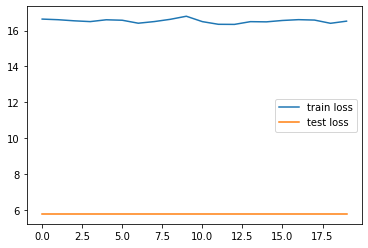

In [86]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses,label='train loss')
plt.plot(test_losses,label='test loss')
plt.legend()

In [87]:
# Accuracy- write a function to get accuracy
# use this function to get train/test accuracy and print accuracy
def get_accuracy(train_loader, test_loader, model):
  model.eval()
  with torch.no_grad():
    correct_train=correct_test=0
    total_train=total_test=0
    
    for input, targets in train_loader:
      input= input.to(device)
      targets= targets.to(device)
      #input = input.view(-1, 784)
      output=model(input)
      _,indices = torch.max(output,dim=1)
      correct_train+= (targets==indices).sum().item()
      total_train += targets.shape[0]
    
    train_acc= correct_train/total_train

    for input, targets in test_loader:
      input= input.to(device)
      targets= targets.to(device)
      #input = input.view(-1, 784)
      output=model(input)
      _,indices = torch.max(output,dim=1)
      correct_test+= (targets==indices).sum().item()
      total_test += targets.shape[0]
    
    test_acc= correct_test/total_test
    return train_acc, test_acc

In [88]:
train_acc, test_acc = get_accuracy(train_loader, test_loader, model)
print(f'Train acc: {train_acc:.4f},\t Test acc: {test_acc:.4f}')

Train acc: 0.0420,	 Test acc: 0.0410


# Q6

- Retrain your model using 1cycle scheduling and see if it improves training speed and model accuracy.

<b>Answer:</b> Training Score improves 

In [89]:
from torch.optim.lr_scheduler import  OneCycleLR

In [90]:
# STEP 5: INSTANTIATE LOSS CLASS
criterion = nn.CrossEntropyLoss()

# STEP 6: INSTANTIATE OPTIMIZER CLASS
learning_rate = 0.05
wd=0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=wd)
scheduler = OneCycleLR(optimizer, max_lr=0.01,steps_per_epoch=50,epochs=10)

In [91]:
# https://discuss.pytorch.org/t/how-to-create-mlp-model-with-arbitrary-number-of-hidden-layers/13124/2
#STEP 3: CREATE MODEL CLASS

class He_Selu(nn.Module):
    def __init__(self, input_dim, h_sizes, output_dim):
        super(He_Selu, self).__init__()
        
                
        # Linear function - hidden layers
        self.hidden = nn.ModuleList()
        for k in range(len(h_sizes)-1):
            self.hidden.append(nn.Linear(h_sizes[k], h_sizes[k+1]))
            nn.init.kaiming_normal_(self.hidden[2*k].weight)

            ### dropout layer added ####

            self.hidden.append(nn.Dropout(p=dropout[k]))
            #print(k)

        # Linear function - output
        self.fc3 = nn.Linear(h_sizes[-1], output_dim) 
        # Weight initialization 
        nn.init.kaiming_normal_(self.fc3.weight)

        # Non-linearity
        # using nn.functional and hence commneted the line below
        #self.srelu = nn.SeLU()
    
    def forward(self, x):
        out =x        
        # Hidden-1-- Linear function
        for i, layer in enumerate(self.hidden):
            
            out = F.selu(layer(out))
            # out = F.dropout(out,p=dropout[i])

        # Output-- Linear function
        out = self.fc3(out)
        return out

# STEP 4: INSTANTIATE MODEL
input_dim = 1000
h_sizes=[1000] + [500]*6
dropout = [0.5]*7
output_dim = 10

model = He_Selu(input_dim, h_sizes,output_dim)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

cuda:0


He_Selu(
  (hidden): ModuleList(
    (0): Linear(in_features=1000, out_features=500, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=500, out_features=500, bias=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=500, out_features=500, bias=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=500, out_features=500, bias=True)
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=500, out_features=500, bias=True)
    (11): Dropout(p=0.5, inplace=False)
  )
  (fc3): Linear(in_features=500, out_features=10, bias=True)
)

In [92]:
# STEP 7: TRAIN THE MODEL
train_losses= np.zeros(epochs)
test_losses= np.zeros(epochs)
learning_rates=[]

for epoch in range(epochs):
  
  t0= datetime.now()
  train_loss=[]
  
  model.train()
  for input,targets in train_loader:
    # load input and output to GPU
    input = input.to(device)
    targets= targets.to(device)
    
    # forward pass
    output= model(input)
    loss=criterion(output,targets)

    # set gradients to zero 
    optimizer.zero_grad()

    # backward pass
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
  
  scheduler.step()

  train_loss=np.mean(train_loss)
      
  test_loss=[]
  model.eval()
  with torch.no_grad():
    for input,targets in test_loader:
      # load input and output to GPU
      input = input.to(device)
      targets= targets.to(device)
      
      # forward pass
      output= model(input)
      loss=criterion(output,targets)
      test_loss.append(loss.item())

    test_loss=np.mean(test_loss)
  
  # save Losses
  train_losses[epoch]= train_loss
  test_losses[epoch]= test_loss
  dt= datetime.now()-t0

  learning_rates.append(scheduler.get_last_lr())
  
  print(f'Epoch {epoch+1}/{epochs}, Learning Rate : {scheduler.get_last_lr()}')
  print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}    Test Loss: {test_loss:.4f}, Duration: {dt}')
  scheduler.step() 


Epoch 1/20, Learning Rate : [0.0004010668966738327]
Epoch 1/20, Train Loss: 11.7861    Test Loss: 4.7701, Duration: 0:00:00.831139
Epoch 2/20, Learning Rate : [0.0004095992246040507]
Epoch 2/20, Train Loss: 11.8851    Test Loss: 4.7701, Duration: 0:00:00.816974
Epoch 3/20, Learning Rate : [0.00042664871029679877]
Epoch 3/20, Train Loss: 12.1094    Test Loss: 4.7701, Duration: 0:00:00.828894
Epoch 4/20, Learning Rate : [0.0004521850403887001]
Epoch 4/20, Train Loss: 11.9314    Test Loss: 4.7701, Duration: 0:00:00.810658
Epoch 5/20, Learning Rate : [0.0004861628122167505]
Epoch 5/20, Train Loss: 11.7849    Test Loss: 4.7701, Duration: 0:00:00.822732
Epoch 6/20, Learning Rate : [0.0005285216145425892]
Epoch 6/20, Train Loss: 12.0077    Test Loss: 4.7701, Duration: 0:00:00.824921
Epoch 7/20, Learning Rate : [0.0005791861349614819]
Epoch 7/20, Train Loss: 11.8656    Test Loss: 4.7701, Duration: 0:00:00.837811
Epoch 8/20, Learning Rate : [0.0006380662938050251]
Epoch 8/20, Train Loss: 12.141

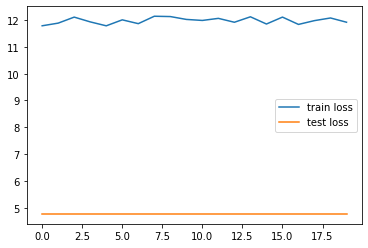

In [93]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses,label='train loss')
plt.plot(test_losses,label='test loss')
plt.legend()

In [94]:
# Accuracy- write a function to get accuracy
# use this function to get train/test accuracy and print accuracy
def get_accuracy(train_loader, test_loader, model):
  model.eval()
  with torch.no_grad():
    correct_train=correct_test=0
    total_train=total_test=0
    
    for input, targets in train_loader:
      input= input.to(device)
      targets= targets.to(device)
      #input = input.view(-1, 784)
      output=model(input)
      _,indices = torch.max(output,dim=1)
      correct_train+= (targets==indices).sum().item()
      total_train += targets.shape[0]
    
    train_acc= correct_train/total_train

    for input, targets in test_loader:
      input= input.to(device)
      targets= targets.to(device)
      #input = input.view(-1, 784)
      output=model(input)
      _,indices = torch.max(output,dim=1)
      correct_test+= (targets==indices).sum().item()
      total_test += targets.shape[0]
    
    test_acc= correct_test/total_test
    return train_acc, test_acc

In [95]:
train_acc, test_acc = get_accuracy(train_loader, test_loader, model)
print(f'Train acc: {train_acc:.4f},\t Test acc: {test_acc:.4f}')

Train acc: 0.0982,	 Test acc: 0.0867


# The End